In [559]:
import numpy as np
import pandas as pd
import sdv
import matplotlib.pyplot as plt
from matplotlib import style # import style module
import datetime
from sdv.sampling import Condition
from deepecho import PARModel
from sdv.timeseries import PAR
import math
from scipy.stats import pearsonr
from operator import truediv
from termcolor import colored
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import normalize, PolynomialFeatures
from sklearn.linear_model import LinearRegression
import csv

In [4]:
def moving_avarage_smoothing(X,k):
    S = np.zeros(X.shape[0])
    for t in range(X.shape[0]):
        if t < k:
            S[t] = np.mean(X[:t+1])
        else:
            S[t] = np.sum(X[t-k:t])/k
    return S

def data_loader (excel, subject_id):
    data = pd.read_excel(excel, subject_id, skiprows=0)
    return data

def process (data):
    data = data.to_numpy()
    data_frame = {'serial': [], 'Meal_id': [], 'Ch': [], 'Fat': [], 'Fiber': [], 'Insulin': [], 'DFB': [], 'SBGL': [], 'CGM': []}
    data_frame = pd.DataFrame(data=data_frame)
    
    CGM=np.zeros((data.shape[0]*120))
    data_frame["CGM"]=CGM
    for i in range(0,data.shape[0]):
        data_frame["serial"][i*120:(i+1)*120] = pd.date_range(datetime.datetime(2018, 1, 1), periods=120, freq="1d")
        data_frame["CGM"][i*120:(i+1)*120] = data[i,9:129].T
        data_frame["Meal_id"][i*120:(i+1)*120] = data[i,0]
        data_frame["Ch"][i*120:(i+1)*120] = data[i,1]
        data_frame["Fat"][i*120:(i+1)*120] = data[i,2]
        data_frame["Fiber"][i*120:(i+1)*120] = data[i,3]
        data_frame["Insulin"][i*120:(i+1)*120] = data[i,5]
        data_frame["DFB"][i*120:(i+1)*120] = data[i,7]
        data_frame["SBGL"][i*120:(i+1)*120] = data[i,9]

    data_frame["Meal_id"] = data_frame["Meal_id"].astype('int32')
    data_frame['serial']=pd.to_datetime(data_frame['serial'], utc=False)
    
    return data_frame

In [23]:
excel_file = pd.ExcelFile('customCGM.xlsx')

#P1 = data_loader(excel_file, 'P01')
#P1 = process(P1)


#P2 = data_loader(excel_file, 'P02')
#P2 = process(P2)


#P3 = data_loader(excel_file, 'P03')
#P3 = process(P3)

P4 = data_loader(excel_file, 'P04')
P4 = process(P4)


#P5 = data_loader(excel_file, 'P05')
#P5 = process(P5)

#P_train = process(P_n)
#P_hyper = process(P_h)

C:\Users\Tech Land\AppData\Local\Temp\ipykernel_2368\651109165.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame["CGM"][i*120:(i+1)*120] = data[i,9:129].T
C:\Users\Tech Land\AppData\Local\Temp\ipykernel_2368\651109165.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame["Meal_id"][i*120:(i+1)*120] = data[i,0]
C:\Users\Tech Land\AppData\Local\Temp\ipykernel_2368\651109165.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

In [467]:
data_types = {
    'Ch': 'continuous',
    'Fat': 'continuous',
    'Fiber': 'continuous',
    'Insulin': 'continuous',
    'DFB': 'continuous',
    'SBGL': 'continuous',
    'CGM': 'continuous',
}

model = PARModel(epochs=2100, cuda=True)

model.fit(
    data=P4,
    entity_columns=['Meal_id'],
    context_columns=['Ch','Fat','Fiber','Insulin','DFB','SBGL'],
    data_types=data_types,
    sequence_index='serial'
)

PARModel(epochs=2100, sample_size=1, cuda='cpu', verbose=True) instance created


C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\sequences.py:181: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for _, sequence in data.groupby(entity_columns):
Epoch 2100 | Loss -2.794125556945801: 100%|████████████████████████████████████████| 2100/2100 [07:31<00:00,  4.66it/s]


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.53it/s]
C:\Users\Tech Land\AppData\Local\Temp\ipykernel_2368\651109165.py:5: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  S[t] = np.mean(X[:t+1])
C:\Users\Tech Land\AppData\Local\Temp\ipykernel_2368\651109165.py:7: FutureWarning: The behavior of `series[i:j]` wi

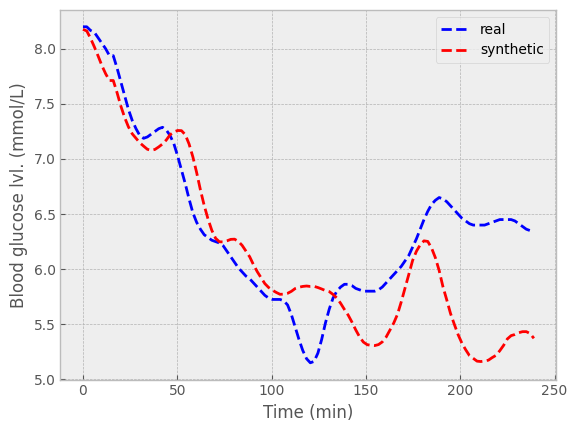

In [516]:
context = pd.DataFrame([
    {
        'Ch': P4.iloc[23*120]['Ch']+2,
        'Fat': P4.iloc[23*120]['Fat'],
        'Fiber': P4.iloc[23*10]['Fiber'],
        'Insulin': P4.iloc[23*120]['Insulin']-0.02,
        'DFB': P4.iloc[23*120]['DFB'],
        'SBGL': P4.iloc[23*120]['SBGL'],
    },
])

sample=model.sample(num_entities=1,context=context)

plt.plot(np.linspace(0, 239, num=120),moving_avarage_smoothing(P4['CGM'][23*120:24*120],8),'blue',linestyle='dashed')
plt.plot(np.linspace(0, 239, num=120),moving_avarage_smoothing(sample["CGM"],8),'red',linestyle='dashed')
plt.xlabel('Time (min)')
plt.ylabel('Blood glucose lvl. (mmol/L)')
plt.legend(['real', 'synthetic'],labelcolor='black')
plt.show()

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]
C:\Users\Tech Land\AppData\Local\Temp\ipykernel_2368\651109165.py:5: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  S[t] = np.mean(X[:t+1])
C:\Users\Tech Land\AppData\Local\Temp\ipykernel_2368\651109165.py:7: FutureWarning: The behavior of `series[i:j]` wi

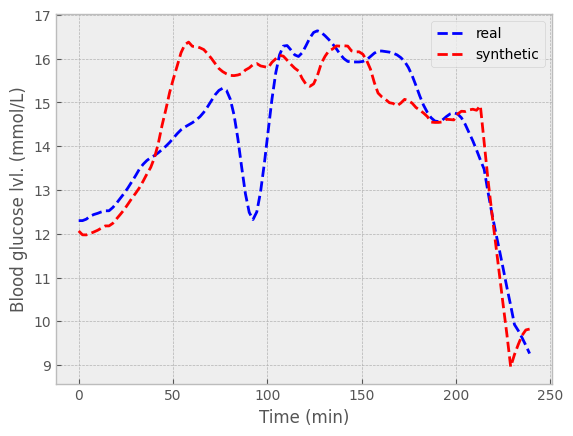

In [514]:
context = pd.DataFrame([
    {
        'Ch': P4.iloc[18*120]['Ch'],
        'Fat': P4.iloc[18*120]['Fat'],
        'Fiber': P4.iloc[18*10]['Fiber'],
        'Insulin': P4.iloc[18*120]['Insulin'],
        'DFB': P4.iloc[18*120]['DFB'],
        'SBGL': P4.iloc[18*120]['SBGL'],
    },
])

sample=model.sample(num_entities=1,context=context)

plt.style.use('bmh')
plt.plot(np.linspace(0, 239, num=120),moving_avarage_smoothing(P4['CGM'][18*120:19*120],8),'blue',linestyle='dashed')
plt.plot(np.linspace(0, 239, num=120),moving_avarage_smoothing(sample["CGM"],8),'red',linestyle='dashed')
plt.xlabel('Time (min)')
plt.ylabel('Blood glucose lvl. (mmol/L)')
plt.legend(['real', 'synthetic'],labelcolor='black')
plt.show()

r = 0.8543410320191629


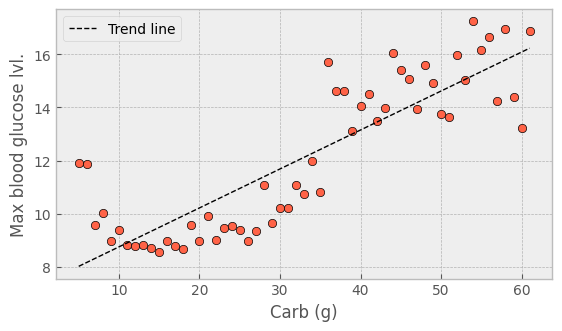

In [557]:
Max = []
Carb = []

for i in range (round(min(P4.iloc[:]['Ch'])), math.floor(max(P4.iloc[:]['Ch'])), 1):
    context = pd.DataFrame([
        {
            'Ch': i,
            'Fat': P4.iloc[21*120]['Fat'],
            'Fiber': P4.iloc[21*120]['Fiber'],
            'Insulin': P4.iloc[18*120]['Insulin'],
            'DFB': P4.iloc[25*120]['DFB'],
            'SBGL': P4.iloc[25*120]['SBGL'],
        },
    ])
    Max.append(np.max(model.sample(num_entities=1,context=context)['CGM']))
    Carb.append(i)

print('r =', np.corrcoef(Carb, Max)[1,0])
plt.figure(figsize=(6.4,3.5))
plt.scatter(Carb, Max, c='tomato',edgecolors='black')
plt.xlabel('Carb (g)')
plt.ylabel('Max blood glucose lvl.')
z = np.polyfit(Carb, Max, 1)
p = np.poly1d(z)
plt.plot(Carb, p(Carb), color="black", linewidth=1, linestyle="--", label="Trend line")
plt.legend()

r = -0.9252498526059978


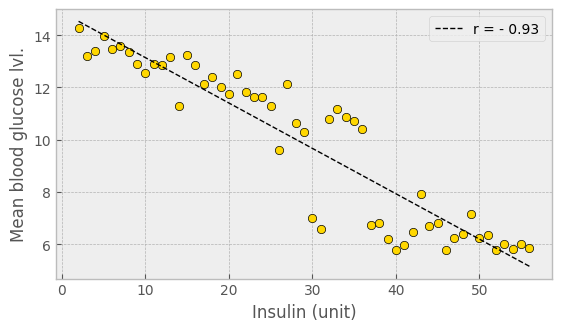

In [532]:
Mean = []
Insulin = []
for i in range (round(min(P4.iloc[:]['Insulin'])*100), math.floor(max(P4.iloc[:]['Insulin'])*100), 1):
    context = pd.DataFrame([
        {
            'Ch': P4.iloc[18*120]['Ch'],
            'Fat': P4.iloc[21*120]['Fat'],
            'Fiber': P4.iloc[13*120]['Fiber'],
            'Insulin': i*0.01,
            'DFB': P4.iloc[15*120]['DFB'],
            'SBGL': 11.5,
        },
    ])
    Mean.append(np.mean(model.sample(num_entities=1,context=context)['CGM']))
    Insulin.append(i)

print('r =', np.corrcoef((np.array(Insulin)).reshape(1, -1), (np.array(Mean)).reshape(1, -1))[1,0])
plt.figure(figsize=(6.4,3.5))
plt.scatter(Insulin, Mean, c='gold',edgecolors='black')
plt.xlabel('Insulin (unit)')
plt.ylabel('Mean blood glucose lvl.')
z = np.polyfit(Insulin, Mean, 1)
p = np.poly1d(z)
plt.plot(Insulin, p(Insulin), color="black", linewidth=1, linestyle="--", label="r = - 0.93")
plt.legend()

In [560]:
def evaluate (model, P):
    cgm = (P['CGM'].to_numpy()).reshape((round(P['CGM'].shape[0]/120),120))
    mean_cgm = np.mean(cgm)
    TIR_percentage = ((3.9<=cgm) & (cgm<9.99)).sum()/(cgm.shape[0]*cgm.shape[1])*100
    hyper_precentage = ((9.99<=cgm)).sum()/(cgm.shape[0]*cgm.shape[1])*100
    L1_hypo_percentage = ((3.0<=cgm) & (cgm<3.9)).sum()/(cgm.shape[0]*cgm.shape[1])*100
    L2_hypo_percentage = ((cgm<3.0)).sum()/(cgm.shape[0]*cgm.shape[1])*100
    excel = pd.ExcelFile('P4 context with LRknn.xlsx')
    test_data = pd.read_excel(excel)
    mean_sample, hyper_sample, L1_hypo_sample, L2_hypo_sample, TIR_sample = [], [], [], [], []

    f = open('Synthetic data/Generated CGMs -- USDA P4.csv', 'w')
    for i in range (0,test_data.shape[0]):
        if ((test_data.iloc[i][2]<max(P['Ch'])) & (test_data.iloc[i][2]>min(P['Ch'])) & (test_data.iloc[i][3]<max(P['Fat'])) & (test_data.iloc[i][3]>min(P['Fat'])) & (test_data.iloc[i][4]<max(P['Fiber'])) & (test_data.iloc[i][4]>min(P['Fiber'])) & (test_data.iloc[i][5]<max(P['Insulin'])) & (test_data.iloc[i][5]>min(P['Insulin'])) & (test_data.iloc[i][6]<max(P['DFB'])) & (test_data.iloc[i][6]>min(P['DFB']))):
            context = pd.DataFrame([{'Ch': test_data.iloc[i][2],'Fat': test_data.iloc[i][3],'Fiber': test_data.iloc[i][4],'Insulin': test_data.iloc[i][5],'DFB': test_data.iloc[i][6],'SBGL': test_data.iloc[i][7]}]) 
            sample=model.sample(num_entities=1,context=context)
            mean_sample.extend([np.mean(sample['CGM'].to_numpy())])
            
            TIR_sample.extend([((3.9<=sample['CGM']) & (sample['CGM']<9.99)).sum()/120*100])
            hyper_sample.extend([((9.99<=sample['CGM'])).sum()/120*100])
            L1_hypo_sample.extend([((3.0<=sample['CGM']) & (sample['CGM']<3.9)).sum()/120*100])
            L2_hypo_sample.extend([(sample['CGM']<3.0).sum()/120*100])
            writer = csv.writer(f)
            writer.writerow(np.round_(sample['CGM'].to_numpy().T, decimals = 1))
    print(colored("Real mean:",'blue'),mean_cgm,colored("Synthetic mean:",'red'),np.mean(mean_sample))
    print(colored("Real TIR:",'blue'),TIR_percentage,colored("Synthetic TIR:",'red'),np.mean(TIR_sample))
    print(colored("Real hyper:",'blue'),hyper_precentage,colored("Synthetic hyper:",'red'),np.mean(hyper_sample))
    print(colored("Real L1 hypo:",'blue'),L1_hypo_percentage,colored("Synthetic L1 hypo:",'red'),np.mean(L1_hypo_sample))
    print(colored("Real L2 hypo:",'blue'),L2_hypo_percentage,colored("Synthetic L2 hypo:",'red'),np.mean(L2_hypo_sample))
    f.close()
    return

evaluate (model, P4)

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(group)
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Tech Land\Anaconda3\envs\Z\lib\site-packages\deepecho\models\base.py:251: FutureWarning: The frame.append method is deprecated and will be

Real mean: 7.804754901960783 Synthetic mean: 6.518197548629673
Real TIR: 81.54411764705883 Synthetic TIR: 81.58986175115207
Real hyper: 16.936274509803923 Synthetic hyper: 9.708490434296884
Real L1 hypo: 0.9803921568627451 Synthetic L1 hypo: 6.366429269655077
Real L2 hypo: 0.5392156862745098 Synthetic L2 hypo: 2.3352185448959646


In [ ]:
P = P4
excel = pd.ExcelFile('P4 context with LRknn.xlsx')
test_data = pd.read_excel(excel)
print(test_data)
f = open('Synthetic data/Filtered Context P4.csv', 'w')
for i in range (0,test_data.shape[0]):
    if ((test_data.iloc[i][2]<max(P['Ch'])) & (test_data.iloc[i][2]>min(P['Ch'])) & (test_data.iloc[i][3]<max(P['Fat'])) & (test_data.iloc[i][3]>min(P['Fat'])) & (test_data.iloc[i][4]<max(P['Fiber'])) & (test_data.iloc[i][4]>min(P['Fiber'])) & (test_data.iloc[i][5]<max(P['Insulin'])) & (test_data.iloc[i][5]>min(P['Insulin'])) & (test_data.iloc[i][6]<max(P['DFB'])) & (test_data.iloc[i][6]>min(P['DFB']))):
        writer = csv.writer(f)
        writer.writerow(test_data.iloc[i])
f.close()